In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import shap
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

AUC of Isolation Forest: 0.884
AUC of Naive amount-based approach: 0.790
AUC of Random guessing: 0.500


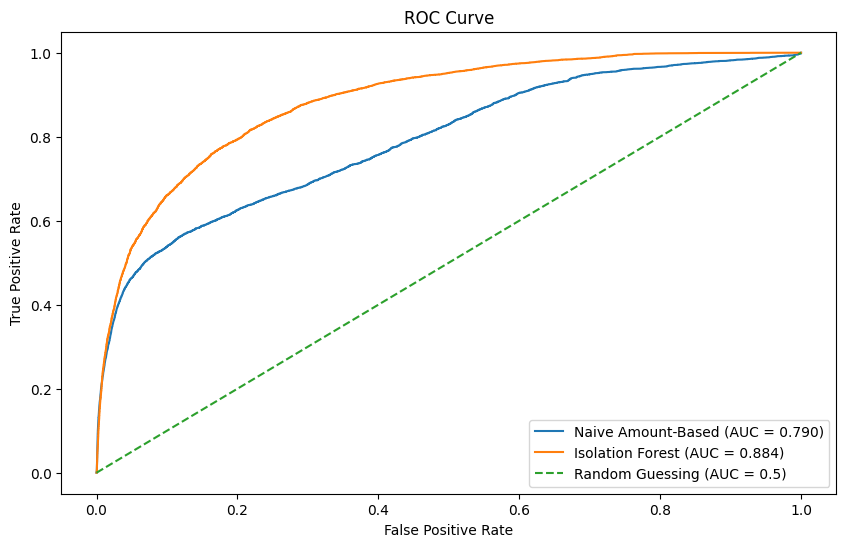

In [4]:

transactions = pd.read_csv('/home/ntak-mac/blobfuse_mnt/datasets/PS_20174392719_1491204439457_log.csv')
features = pd.DataFrame(index=transactions.index)

# numerical features
numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'] 
features[numerical_columns] = transactions[numerical_columns]

# engineered features
features['changebalanceOrig'] = features['newbalanceOrig'] - features['oldbalanceOrg']
features['changebalanceDest'] = features['newbalanceDest'] - features['oldbalanceDest'] 

features['hour'] = transactions['step'] % 24

# One-hot encoding for categorical features
type_one_hot = pd.get_dummies(transactions['type'])
features = pd.concat([features, type_one_hot], axis=1)


forest = IsolationForest(random_state=0)
forest.fit(features)

# get anomaly Scores
scores = forest.score_samples(features)

# evalluation - IF AUC
y_true = transactions['isFraud']
auc_isolation_forest = roc_auc_score(y_true, -scores)  # negative scores as higher score means more anomalous
print(f"AUC of Isolation Forest: {auc_isolation_forest:.3f}")

fpr, tpr, _ = roc_curve(y_true, transactions['amount'])
auc_naive = roc_auc_score(y_true, transactions['amount'])
print(f"AUC of Naive amount-based approach: {auc_naive:.3f}")

# 3. random guessing AUC (should be around 0.5)
print(f"AUC of Random guessing: {0.5:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Naive Amount-Based (AUC = {auc_naive:.3f})')
fpr, tpr, _ = roc_curve(y_true, -scores)
plt.plot(fpr, tpr, label=f'Isolation Forest (AUC = {auc_isolation_forest:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [5]:

explainer = shap.TreeExplainer(forest)

# get sample
random_indices = np.random.choice(len(features), 5000)
shap_values_random = explainer.shap_values(features.iloc[random_indices, :])
random_features = features.iloc[random_indices,:]

# local explanation
shap.force_plot(explainer.expected_value, shap_values_random[0, :], random_features.iloc[0, :])

shap_values_adjusted = shap_values_random.copy()
feature_names_adjusted = random_features.columns.tolist()
type_columns = ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']
for i, col in enumerate(type_columns):
    shap_values_adjusted[:, feature_names_adjusted.index('type_' + col)] += shap_values_random[:, feature_names_adjusted.index(col)]
    feature_names_adjusted[feature_names_adjusted.index('type_' + col)] = 'type'

# global Explanations
shap.dependence_plot(
    'changebalanceDest',
    shap_values_adjusted,
    random_features,
    interaction_index=None,
    xmax='percentile(99)'
)

shap.dependence_plot(
    'changebalanceDest',
    shap_values_adjusted,
    random_features,
    interaction_index='CASH_OUT',
    xmax='percentile(99)'
)

shap.dependence_plot(
    'hour',
    shap_values_adjusted,
    random_features,
    interaction_index='PAYMENT'
)

SyntaxError: invalid non-printable character U+00A0 (516709761.py, line 6)